#### Importing required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('all')
nltk.download('wordnet')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [3]:
data=pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv')

In [4]:
data.tail()

,Unnamed: 0,title,text,label
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0
72133,72133,Goldman Sachs Endorses Hillary Clinton For Pre...,Goldman Sachs Endorses Hillary Clinton For Pre...,1


In [5]:
data=data.iloc[:,1:4]

In [6]:
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


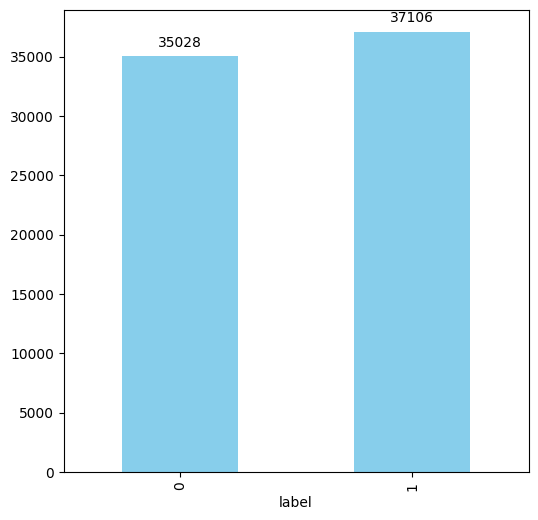

In [7]:
plt.subplots(figsize=(6, 6))
ax=data['label'].value_counts().sort_index().plot(kind='bar', color='skyblue')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [8]:
data.isna().sum()

title    558
text      39
label      0
dtype: int64

In [9]:
data['title'].fillna('Unknown', inplace=True)

In [10]:
data.isna().sum()

title     0
text     39
label     0
dtype: int64

In [11]:
data.dropna()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,Unknown,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [12]:
data.duplicated().sum()

8456

In [13]:
data.drop_duplicates(inplace=True)

In [14]:
data.duplicated().sum()

0

Null values and duplicates handled

## Separating dependent and independent features

In [15]:
X=data.drop('label', axis=1)

In [16]:
X.head()

,title,text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...
1,Unknown,Did they post their votes for Hillary already?
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will..."


### Text pre-processing

In [17]:
msgs=data.copy()
msgs.reset_index(inplace=True)

In [18]:
msgs.sample(5)

,index,title,text,label
10798,10996,Koch network launches effort to kill Republica...,"INDIAN WELLS, Calif. (Reuters) - Billionaire i...",0
50555,55623,Planned Parenthood #PinkOut: ‘Turn the Whole I...,The nation’s largest abortion business is hopi...,0
18544,19145,Two Florida Lawmakers Just Voted Against Hurr...,Two Florida Republican lawmakers voted against...,1
45636,49712,California Today: ‘Zoot Suit’ Memories - The N...,Good morning. (Want to get California Today b...,0
42898,46479,"Congressmen Turned Radio Host, Joe Walsh, Reck...",link This guy didn't even win re-election but ...,1


###### stop words removal and stemming

In [19]:
ps=PorterStemmer()
corpus=[]
for i in range(0, len(msgs)):
    review=re.sub('[^a-zA-Z]',' ', msgs['title'][i])
    review=review.lower().split()
    review=[ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    review=' '.join(review)
    corpus.append(review)

In [20]:
corpus[27]

'islam state driven last stronghold northern iraq'

##### Vectorizing the text using BOW

In [21]:
cv=CountVectorizer(max_features=5000,ngram_range=(1,3))
X=cv.fit_transform(corpus).toarray()

In [22]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
X.shape

(63678, 5000)

In [24]:
y=data['label']

In [25]:
cv.get_feature_names_out()[:20]

array(['abandon', 'abba', 'abc', 'abc news', 'abduct', 'abe', 'abedin',
       'abl', 'abort', 'abort law', 'abroad', 'absolut', 'absurd', 'abus',
       'academ', 'accept', 'access', 'access pipelin', 'accid',
       'accident'], dtype=object)

In [26]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [27]:
count_df=pd.DataFrame(X,columns=cv.get_feature_names_out())
count_df.tail()

,abandon,abba,abc,abc news,abduct,abe,abedin,abl,abort,abort law,...,zero,zika,zika fund,zika viru,zimbabw,zimbabw mugab,zone,zor,zuckerberg,zuma
63673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Train-Test Split

In [28]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2,random_state=42)

### Applying the Models

#### 1. MulinomialNB Algorithm

In [29]:
classifier=MultinomialNB()
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)

In [30]:
accuracy_score(y_test, y_pred)

0.8670697236180904

In [31]:
confusion_matrix(y_test, y_pred)

array([[6027,  998],
       [ 695, 5016]])

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      7025
           1       0.83      0.88      0.86      5711

    accuracy                           0.87     12736
   macro avg       0.87      0.87      0.87     12736
weighted avg       0.87      0.87      0.87     12736



In [33]:
classifier=PassiveAggressiveClassifier(max_iter=5000,C=0.5)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)

In [34]:
accuracy_score(y_test,y_pred)

0.8656564070351759

In [35]:
confusion_matrix(y_test, y_pred)

array([[6085,  940],
       [ 771, 4940]])

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      7025
           1       0.84      0.86      0.85      5711

    accuracy                           0.87     12736
   macro avg       0.86      0.87      0.86     12736
weighted avg       0.87      0.87      0.87     12736



#### Hyper-parameter tuning

In [37]:
classifier=MultinomialNB(alpha=0.1)

In [38]:
prev_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train, y_train)
    y_pred=sub_classifier.predict(X_test)
    score=accuracy_score(y_test, y_pred)
    if score>prev_score:
        classifier=sub_classifier
    print("Alpha:{}, Score:{}".format(alpha,score))

/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


Alpha:0.0, Score:0.8656564070351759
Alpha:0.1, Score:0.8665201005025126
Alpha:0.2, Score:0.8667556532663316
Alpha:0.30000000000000004, Score:0.8665986180904522
Alpha:0.4, Score:0.8668341708542714
Alpha:0.5, Score:0.866677135678392
Alpha:0.6000000000000001, Score:0.8665986180904522
Alpha:0.7000000000000001, Score:0.8667556532663316
Alpha:0.8, Score:0.8667556532663316
Alpha:0.9, Score:0.866912688442211


In [39]:
prev_score=0
for alpha in np.arange(0.1,1,0.1):
    sub_classifier=PassiveAggressiveClassifier(C=alpha, max_iter=5000,shuffle=False )
    sub_classifier.fit(X_train, y_train)
    y_pred=sub_classifier.predict(X_test)
    score=accuracy_score(y_test, y_pred)
    if score>prev_score:
        classifier=sub_classifier
    print("Alpha:{}, Score:{}".format(alpha,score))

Alpha:0.1, Score:0.8677763819095478
Alpha:0.2, Score:0.8508951005025126
Alpha:0.30000000000000004, Score:0.842964824120603
Alpha:0.4, Score:0.836447864321608
Alpha:0.5, Score:0.828910175879397
Alpha:0.6, Score:0.8286746231155779
Alpha:0.7000000000000001, Score:0.8276538944723618
Alpha:0.8, Score:0.8299309045226131
Alpha:0.9, Score:0.8309516331658291


In [40]:
classifier=PassiveAggressiveClassifier(max_iter=5000,C=0.1)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)

In [41]:
accuracy_score(y_test, y_pred)

0.8814384422110553

In [42]:
feature_names=cv.get_feature_names_out()

In [43]:
classifier.coef_[0]

array([ 0.31453119, -1.20822281, -0.72465644, ..., -0.75205768,
       -0.52031213, -1.35252792])

#### First 20 MOST REAL WORD

In [44]:
sorted(zip(classifier.coef_[0], feature_names), reverse=True)[:20]

[(4.414075967221994, 'daesh'),
 (4.0481226065459985, 'dem senat'),
 (3.9429174158624014, 'hilari'),
 (3.914857162637477, 'russia news'),
 (3.836934081732064, 'chart day'),
 (3.7984872470347435, 'wow'),
 (3.5054497449019437, 'whoa'),
 (3.4880468789902093, 'presstv'),
 (3.465153346241126, 'beg'),
 (3.4367881556054773, 'lol'),
 (3.428690887497296, 'bundi'),
 (3.381540033088935, 'anti lgbt'),
 (3.3742690879902706, 'columnist'),
 (3.251809010023216, 'lawless'),
 (3.2264768649166577, 'neocon'),
 (3.100457328171929, 'guess'),
 (3.01439341064812, 'justin'),
 (2.964619723004182, 'shocker'),
 (2.941094291902844, 'moron'),
 (2.919827791490699, 'big pharma')]

#### Most Fakest words

In [45]:
sorted(zip(classifier.coef_[0], feature_names))[:20]

[(-5.508609210617985, 'breitbart'),
 (-4.035358957636692, 'factbox'),
 (-3.897169927893451, 'delingpol'),
 (-3.6876115206023545, 'rohingya'),
 (-3.2710224592984796, 'singapor'),
 (-3.252921779408713, 'pruitt'),
 (-3.1930008150803864, 'le pen'),
 (-3.1118301301071183, 'somalia'),
 (-3.1046539815964014, 'lebanes'),
 (-3.090965423410008, 'czech'),
 (-3.069777310471518, 'usa today'),
 (-3.0219497359931657, 'bali'),
 (-2.9839921985997284, 'radic islam'),
 (-2.982276086346504, 'catalan'),
 (-2.9696098216955136, 'persist'),
 (-2.900538082544353, 'thai'),
 (-2.8770604506976745, 'islam state'),
 (-2.8417551591657317, 'nigeria'),
 (-2.8341571622496597, 'clinton call'),
 (-2.715130157516498, 'argentin')]